## This notebook will run and analyse the Model for the Subway Data


## Random forest model training

In [33]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [34]:
##Writing installed packages to requirements.txt file
!pip freeze > subway_requirements.txt

In [35]:
#import the csv file needed to train the model
df=pd.read_csv('cleaned_busyness_data.csv')
df.head(10)

,remote_unit_id,time_stamp,entries,exits,num_people_exited,sum_exit_entry,surrounding_area_busyness,station_busyness,hour,day,month,temperature,weather,rain_fall,snow_fall
0,R001,1546300800,0,0,0,0,61,12,0,Tuesday,January,3.42,Rain,3.06,4.40
1,R001,1546315200,102,104,2,206,61,18,4,Tuesday,January,5.89,Rain,3.77,2.21
2,R001,1546329600,96,51,-45,147,55,16,8,Tuesday,January,11.18,Mist,0.00,0.12
3,R001,1546344000,260,476,216,736,82,42,12,Tuesday,January,13.55,Rain,0.25,0.06
4,R001,1546358400,540,496,-44,1036,55,58,16,Tuesday,January,11.68,Rain,0.50,0.25
5,R001,1546372800,602,250,-352,852,0,48,20,Tuesday,January,3.70,Clouds,0.00,0.05
6,R001,1546387200,159,147,-12,306,59,22,0,Wednesday,January,2.05,Clouds,0.00,0.00
7,R001,1546401600,48,38,-10,86,59,14,4,Wednesday,January,-0.06,Clouds,0.00,0.00
8,R001,1546416000,516,434,-82,950,51,54,8,Wednesday,January,-2.08,Clear,0.00,0.00
9,R001,1546430400,842,1351,509,2193,96,96,12,Wednesday,January,-1.89,Clear,0.00,0.00


In [36]:
#convert monthand day to numerical columns
df['month']=df['month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
                                'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
df['day']=df['day'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})


In [37]:
#convert weather to categorical columns
df['weather']=df['weather'].astype('category')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297835 entries, 0 to 297834
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   remote_unit_id             297835 non-null  object  
 1   time_stamp                 297835 non-null  int64   
 2   entries                    297835 non-null  int64   
 3   exits                      297835 non-null  int64   
 4   num_people_exited          297835 non-null  int64   
 5   sum_exit_entry             297835 non-null  int64   
 6   surrounding_area_busyness  297835 non-null  int64   
 7   station_busyness           297835 non-null  int64   
 8   hour                       297835 non-null  int64   
 9   day                        297835 non-null  int64   
 10  month                      297835 non-null  int64   
 11  temperature                297835 non-null  float64 
 12  weather                    297835 non-null  category
 13  rain_fall     

### Create a correlation matrix to see strength of correlations between feature pairs

/tmp/ipykernel_38271/2506163149.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat=df.corr()


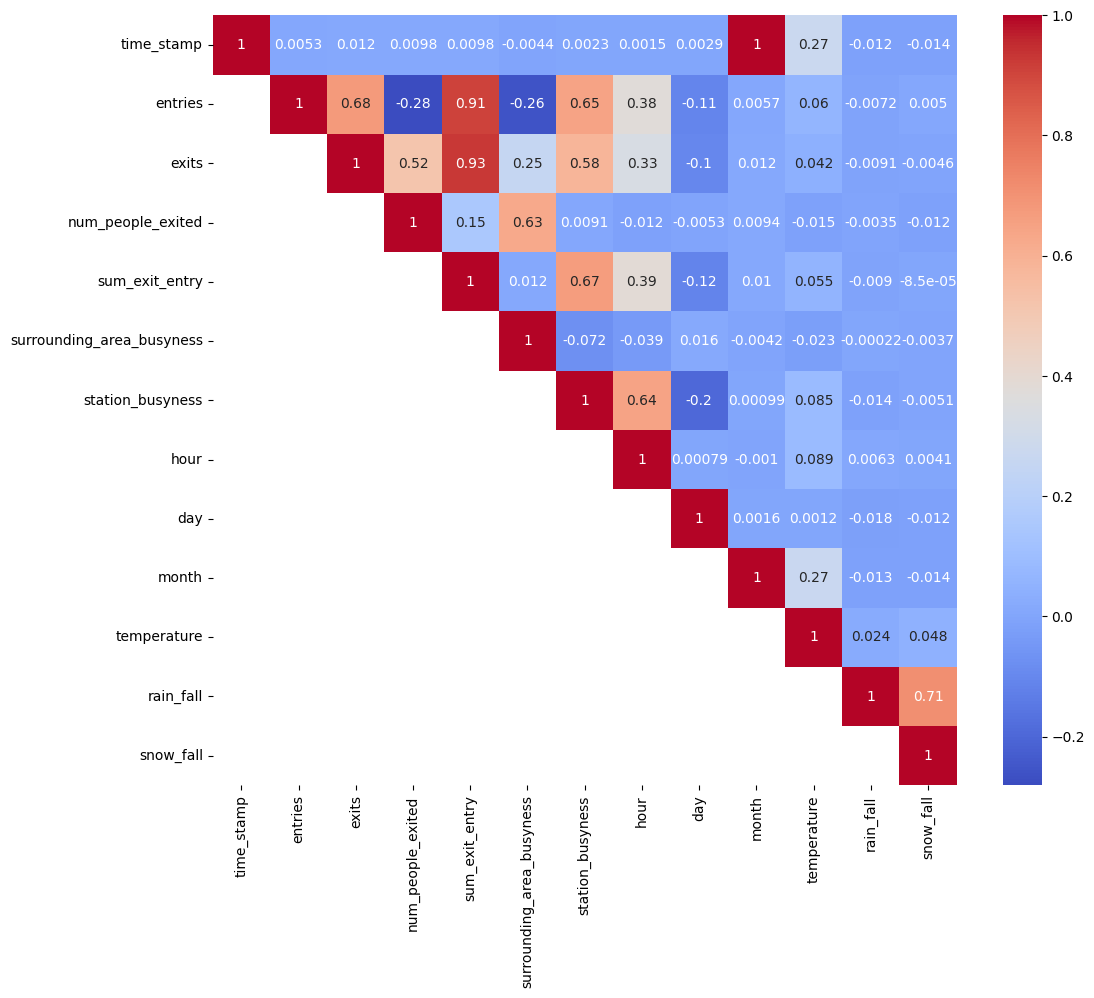

In [39]:
mat=df.corr()

# create a mask to drop the upper triangle
mask = np.triu(np.ones_like(mat, dtype=bool))

# apply the mask to the correlation matrix
mat = mat.where(mask)

fig, ax = plt.subplots(figsize=(12, 10))

sea.heatmap(mat, annot=True, cmap='coolwarm', ax=ax)

# show the plot
plt.show()

In [40]:
df.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits', 'num_people_exited',
       'sum_exit_entry', 'surrounding_area_busyness', 'station_busyness',
       'hour', 'day', 'month', 'temperature', 'weather', 'rain_fall',
       'snow_fall'],
      dtype='object')

## One hot encoding for categorical features


In [41]:
one_hot = pd.get_dummies(df['weather'])
df = pd.concat([df, one_hot], axis = 1)

In [42]:
df.head()

,remote_unit_id,time_stamp,entries,exits,num_people_exited,sum_exit_entry,surrounding_area_busyness,station_busyness,hour,day,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm
0,R001,1546300800,0,0,0,0,61,12,0,2,...,0,0,0,0,0,0,1,0,0,0
1,R001,1546315200,102,104,2,206,61,18,4,2,...,0,0,0,0,0,0,1,0,0,0
2,R001,1546329600,96,51,-45,147,55,16,8,2,...,0,0,0,0,0,1,0,0,0,0
3,R001,1546344000,260,476,216,736,82,42,12,2,...,0,0,0,0,0,0,1,0,0,0
4,R001,1546358400,540,496,-44,1036,55,58,16,2,...,0,0,0,0,0,0,1,0,0,0


## Functions to train the models

- Choose either the busyness percentages or the actual footfall values
- For Busyness percentages use random forest classifer, for actual footfall values use random forest regressor


In [43]:
surrounding_area='num_people_exited'
#surronding_area='surrounding_area_busyness'
station_busy='sum_exit_entry'
#station_busy='station_busyness'

In [56]:

def divide_data_surrounding_area_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['num_people_exited'].values
    #drop these values for query search
    df_inner=df_inner.drop(columns=['num_people_exited','sum_exit_entry','surrounding_area_busyness','station_busyness','remote_unit_id'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months? 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test


def divide_data_station_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['sum_exit_entry'].values
    #drop these values for query search
    #why drop remote unit id- because it is just used to identify which model we need
    df_inner=df_inner.drop(columns=['num_people_exited','sum_exit_entry','surrounding_area_busyness','station_busyness','remote_unit_id'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test

test_mae_list = []
test_rmse_list = []
test_mape_list=[]
test_smape_list=[]
test_rrmse_list=[]
test_theils_u_list=[]
test_score_list = []
test_medae_list=[]

def forest_training_model(train_x, train_y, test_x, test_y):
    #expirement with different parameters here
    forest = RandomForestRegressor(n_estimators=80, max_depth=10)
    forest = forest.fit(train_x, train_y)

    test_predictions = forest.predict(test_x)

    test_mae = mean_absolute_error(test_y, test_predictions)
    test_mae_list.append(test_mae)

    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
    test_rmse_list.append(test_rmse)
    
    test_mape = calculate_mape(test_y, test_predictions)
    test_mape_list.append(test_mape)

    test_smape = calculate_smape(test_y, test_predictions)
    test_smape_list.append(test_smape)

    test_rrmse = test_rmse / np.mean(test_y)
    test_rrmse_list.append(test_rrmse)

    test_theils_u = calculate_theils_u(test_y, test_predictions)
    test_theils_u_list.append(test_theils_u)

    test_r2 = r2_score(test_y, test_predictions)
    test_score_list.append(test_r2)

    test_medae = median_absolute_error(test_y, test_predictions)
    test_medae_list.append(test_medae)

    return forest


def calculate_mape(actual, predicted):
    # Calculate MAPE while handling zero values in actual
    mape = np.mean(np.abs((actual - predicted) / np.where(actual == 0, 1, actual))) * 100
    return mape

def calculate_smape(actual, predicted):
    # Handle zero values in actual
    denominator = np.abs(actual) + np.abs(predicted)
    non_zero_indices = denominator != 0
    smape = 100 * np.mean(2 * np.abs(actual[non_zero_indices] - predicted[non_zero_indices]) / denominator[non_zero_indices])
    return smape


def calculate_theils_u(actual, predicted):
    mse_model = mean_squared_error(actual, predicted)
    mse_naive = mean_squared_error(actual, np.full_like(actual, np.mean(actual)))
    theils_u = np.sqrt(mse_model / mse_naive)
    return theils_u

def median_absolute_error(actual, predicted):
    absolute_errors = np.abs(actual - predicted)
    medae = np.median(absolute_errors)
    return medae


## Description of the error metrics:

### Mean Absolute Error:
- This is the average of the absolute value of the errors between the predicted values and the actual values. This is the most intuitive of the metrics and is the easiest to understand. However, it is also the most sensitive to outliers.

### Mean Absolute Percentage Error:
- This is the average of the absolute percentage errors between the predicted values and the actual values. This metric is similar to the MAE, but it is a relative metric which is useful for comparing the performance of these models.

### Root Mean Squared Error:
- This is the square root of the average of the squared errors between the predicted values and the actual values. This metric is similar to the MSE, but it is in the same units as the dependent variable, which makes it easier to interpret.

### Relative Root Mean Squared Error:
- This is the RMSE divided by the standard deviation of the dependent variable. This metric is similar to the RMSE, but it is a relative metric which is useful for comparing the performance of these models.

### R2 Score:
- This is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). This metric is useful for comparing the performance of these models.

### Symmetric Mean Absolute Percentage Error (SMAPE):
- SMAPE is a symmetric version of Mean Absolute Percentage Error and is useful when you want to penalize both overestimation and underestimation equally.

### Theil's U statistic:
- Theil's U compares the root mean squared error of your model with that of a naive benchmark (e.g., using the mean of the dependent variable as predictions). It indicates how much your model's performance improves over the simple average model


## Function to save the models

In [45]:
def save_model_station_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow/NYSeeNow-ML/SubwayData/station_busy/s_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

def save_model_area_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow/NYSeeNow-ML/SubwayData/area_busy/a_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

### Clean the pickle dataframe 
- In order to reduce the size and time taken to run the models


In [46]:
df.drop(columns=['weather'], inplace=True)
df_pickle=df.copy()


In [47]:
df_pickle.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits', 'num_people_exited',
       'sum_exit_entry', 'surrounding_area_busyness', 'station_busyness',
       'hour', 'day', 'month', 'temperature', 'rain_fall', 'snow_fall',
       'Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke',
       'Snow', 'Thunderstorm'],
      dtype='object')

### Drop features of least importance: thunderstorm, haze, fog, drizzle and smoke


In [48]:
#drop entries exits and timestamp from the pickle model, we wont know these to give to it, 
#and for each pickle one it cant have the other perctenage busyness

df_pickle.drop(columns=['time_stamp', 'entries', 'exits','Thunderstorm', 'Haze', 'Fog','Drizzle', 'Smoke'],axis=1,inplace=True)


In [49]:
df_pickle.columns

Index(['remote_unit_id', 'num_people_exited', 'sum_exit_entry',
       'surrounding_area_busyness', 'station_busyness', 'hour', 'day', 'month',
       'temperature', 'rain_fall', 'snow_fall', 'Clear', 'Clouds', 'Mist',
       'Rain', 'Snow'],
      dtype='object')

In [50]:
df_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297835 entries, 0 to 297834
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   remote_unit_id             297835 non-null  object 
 1   num_people_exited          297835 non-null  int64  
 2   sum_exit_entry             297835 non-null  int64  
 3   surrounding_area_busyness  297835 non-null  int64  
 4   station_busyness           297835 non-null  int64  
 5   hour                       297835 non-null  int64  
 6   day                        297835 non-null  int64  
 7   month                      297835 non-null  int64  
 8   temperature                297835 non-null  float64
 9   rain_fall                  297835 non-null  float64
 10  snow_fall                  297835 non-null  float64
 11  Clear                      297835 non-null  uint8  
 12  Clouds                     297835 non-null  uint8  
 13  Mist                       29

In [51]:
#count the occurances of 1 in the following columns: Clear, Clouds, Drizzle, Fog etc
occurrences = df[['Clear', 'Clouds', 'Mist','Rain','Snow']].sum(axis=0)
occurrences


Clear     138538
Clouds     78392
Mist       18158
Rain       49849
Snow        4073
dtype: int64

## Execute the models

### Get station numbers

In [52]:
df_static = pd.read_csv('cleaned_station_data.csv')
check=df_static["remote_unit_id"]
order=check.tolist()
#now order the stations
order.sort()
#order
len(order)

143

## Code that runs and saves the models

- Keep the save commented to save writing the new models again

In [57]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_surrounding_area_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    #save_model_area_busy(model, station_number)

    #get importances of each feature
    area_importance = pd.DataFrame({'feature': df_station.columns, 'importance':model.feature_importances_})
    area_importance.sort_values('importance', ascending=False)

    #have a mean importance value for each feature
    area_importance['importance'].mean()

#print average scores
print(f"Average test MAE : {np.mean(test_mae_list):.6f}")
print(f"Average test RMSE : {np.mean(test_rmse_list):.6f}")
print(f"Average test MAPE : {np.mean(test_mape_list):.6f}")
print(f"Average test SMAPE : {np.mean(test_smape_list):.6f}")
print(f"Average test RRMSE : {np.mean(test_rrmse_list):.6f}")
print(f"Average test Theil's U : {np.mean(test_theils_u_list):.6f}")
print(f"R squared test score : {np.mean(test_score_list):.6f}")
print(f"Average test MedAE : {np.mean(test_medae_list):.6f}")

Average test MAE : 88.686494
Average test RMSE : 177.051300
Average test MAPE : 263.755410
Average test SMAPE : 58.424193
Average test RRMSE : -4.010981
Average test Theil's U : 0.535737
R squared test score : 0.673534
Average test MedAE : 47.356362


In [58]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_station_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    #save_model_station_busy(model, station_number)

    #get importances
    station_importance = pd.DataFrame({'feature': df_station.columns, 'importance':model.feature_importances_})
    station_importance.sort_values('importance', ascending=False)

    #have a mean importance value for each feature
    station_importance['importance'].mean()
    
#print average scores
print(f"Average test MAE : {np.mean(test_mae_list):.6f}")
print(f"Average test RMSE : {np.mean(test_rmse_list):.6f}")
print(f"Average test MAPE : {np.mean(test_mape_list):.6f}")
print(f"Average test SMAPE : {np.mean(test_smape_list):.6f}")
print(f"Average test RRMSE : {np.mean(test_rrmse_list):.6f}")
print(f"Average test Theil's U : {np.mean(test_theils_u_list):.6f}")
print(f"R squared test score : {np.mean(test_score_list):.6f}")
print(f"Average test MedAE : {np.mean(test_medae_list):.6f}")

Average test MAE : 136.932133
Average test RMSE : 388.459629
Average test MAPE : 291.883788
Average test SMAPE : 41.548735
Average test RRMSE : -1.627643
Average test Theil's U : 0.647964
R squared test score : 0.517182
Average test MedAE : 63.354542


- Conclusion: The model is better at predicting station busyness than surrounding area busyness

## Lets analyse this further- use data hmw2

### Feature Importance for Random Forest for station busyness

In [55]:
#change importance column to % and no decimal places
station_importance['importance %'] = station_importance['importance'].apply(lambda x: round(x*100, 2))
station_importance.sort_values('importance', ascending=False)

,feature,importance,importance %
0,hour,0.332317,33.23
3,temperature,0.206134,20.61
5,snow_fall,0.173843,17.38
1,day,0.112959,11.30
6,Clear,0.077060,7.71
2,month,0.057548,5.75
4,rain_fall,0.025806,2.58
9,Rain,0.008123,0.81
7,Clouds,0.005485,0.55
8,Mist,0.000697,0.07


### Feature Importance for Random Forest for area busyness

In [24]:
#change importance column to % and no decimal places
area_importance['importance %'] = area_importance['importance'].apply(lambda x: round(x*100, 2))
area_importance.sort_values('importance', ascending=False)

,feature,importance,importance %
3,temperature,0.267175,26.72
2,month,0.152480,15.25
1,day,0.136677,13.67
5,snow_fall,0.134054,13.41
0,hour,0.111463,11.15
4,rain_fall,0.080880,8.09
7,Clouds,0.035220,3.52
6,Clear,0.031622,3.16
9,Rain,0.023624,2.36
8,Mist,0.018424,1.84


### Drop features of least importance: thunderstorm, haze, fog, drizzle and smoke

In [27]:
# Lets explore the data
# filter the DataFrame to only include rows where 'Monday' equals 1
df_mondays = df[df['day'] == 1]
#pick one station
df_mondays_1 = df_mondays[df_mondays['remote_unit_id'] == 1]
df_mondays_1.head()

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm


### Make some plots to better understand the busyness for each station

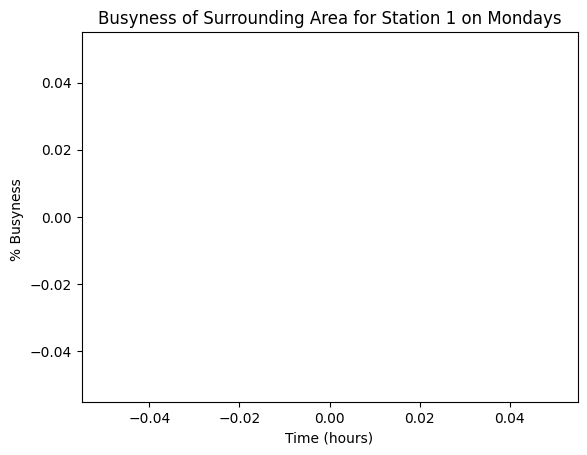

In [28]:
# create scatter plot using the filtered DataFrame
plt.scatter(df_mondays_1['hour'], df_mondays_1['surrounding_area_busyness'])
plt.title("Busyness of Surrounding Area for Station 1 on Mondays")
plt.ylabel("% Busyness ")
plt.xlabel("Time (hours)")
plt.show()


### Description of the models:
- I have made two busyness prediciton models that only need the remote unit id, which can be easily mapped from the lookup table
- Choose surrounding area, or station busyness prediction by selecting the correct folder
- Select the Remote Unit id using the cleaned_station_data.csv file
- The model also requires the following to get the prediciton:
- hour as an int with 0 being midnight, 1 being 1AM etc
- day as an int with 1 being Monday etc
- month as int with 1 being January etc
- temperature as float in Celsius
- rain_fall as float in mm per hour
- snow_fall as float in mm per hour
- Clear as a int, 1 or  0
- Clouds as a int, 1 or  0
- Same for Drizzle, Fog, Haze, Mist, Rain, Smoke, Snow and Thunderstorm

### Plots of some stations over a week

In [29]:
len(df)

297835

In [30]:

def average_station_busyness(numb):
    # filter the DataFrame to only include data for one station
    df_station = df[df['remote_unit_id'] == numb]

    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day','hour'])['station_busyness'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Station Busyness for {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Station Busyness")
    plt.ylim(0, 100)
    plt.show()


def average_area_busyness(numb):
    # filter the DataFrame to only include data for one station
    df_station = df[df['remote_unit_id'] == numb]

    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day','hour'])['surrounding_area_busyness'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Area Busyness for {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Station Busyness")
    plt.ylim(0, 100)
    plt.show()




In [31]:
# we just need to create a collect csv files for both and put them in here
df_static = pd.read_csv('cleaned_station_data.csv')
df_static.head()

,station_name,lat,lon,remote_unit_id,short_name
0,Lexington Av/59 St,40.762660,-73.967258,16,LEXINGTON-53 ST
1,Lexington Av/59 St,40.762660,-73.967258,17,LEXINGTON-53 ST
2,Lexington Av/59 St,40.762660,-73.967258,50,59 ST
3,Lexington Av/59 St,40.762660,-73.967258,51,59 ST
4,5 Av/59 St,40.764811,-73.973347,79,5 AVE-59 ST


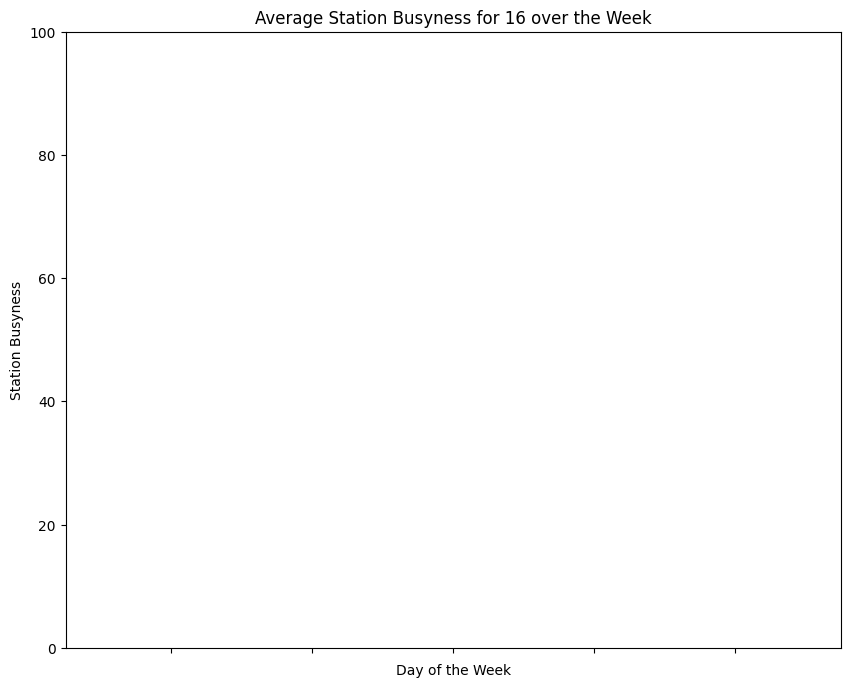

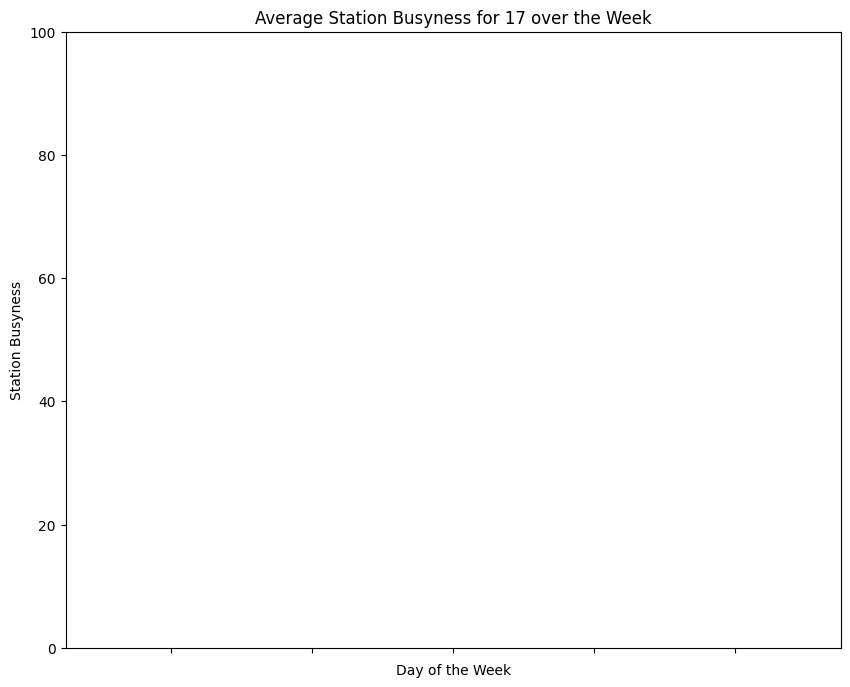

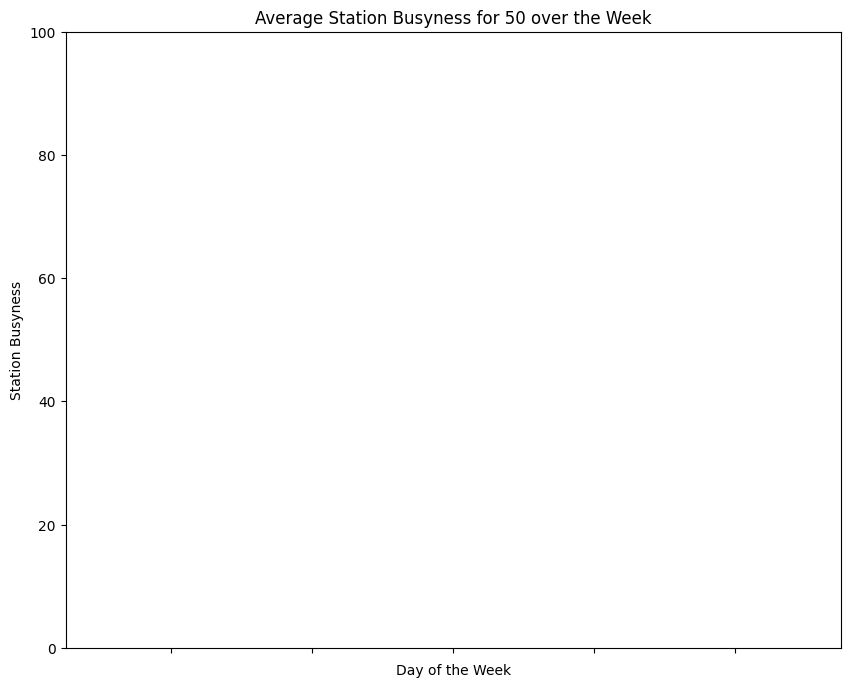

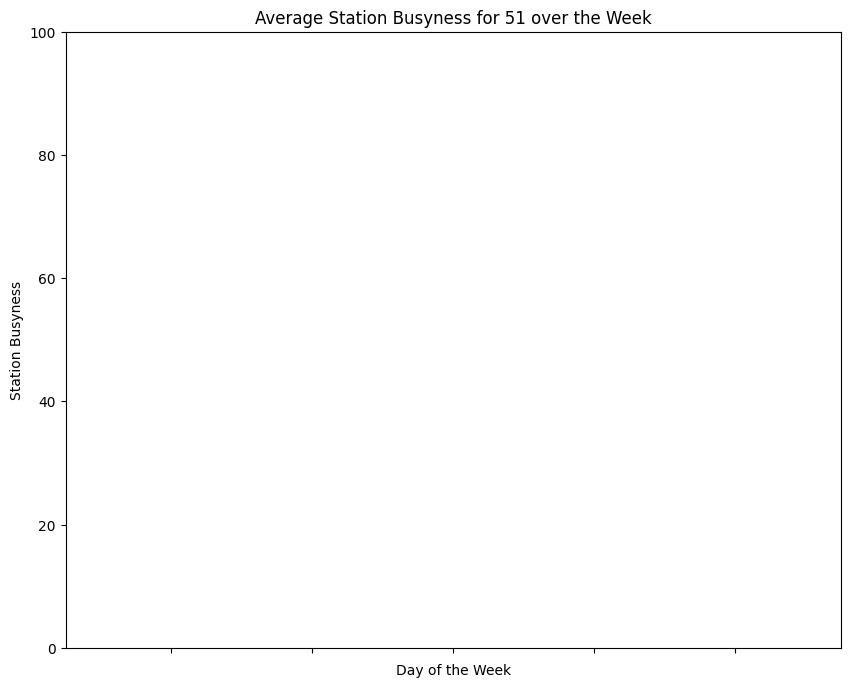

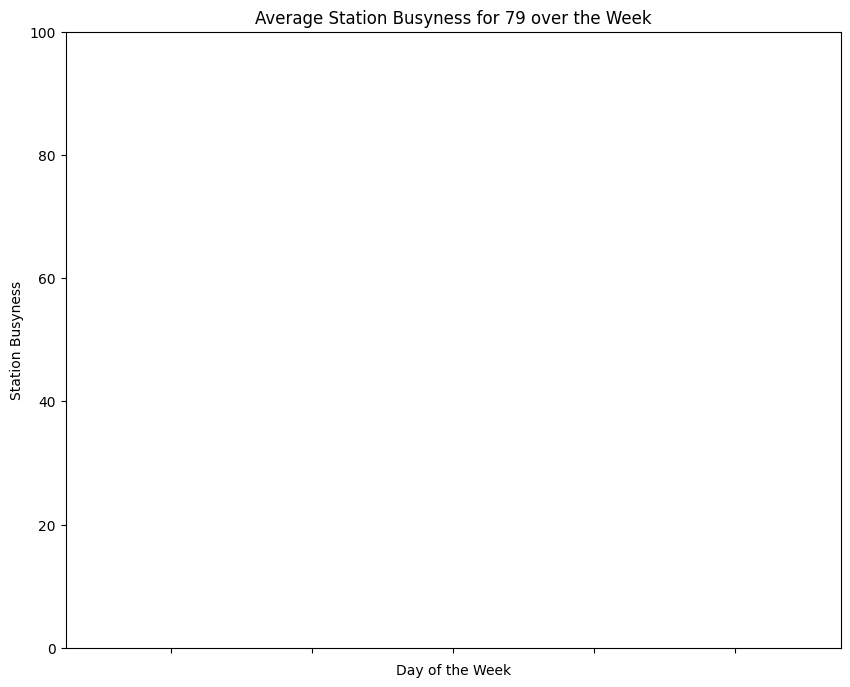

In [32]:
#pick some stations to plot
length = len(df_static['remote_unit_id'])
for i in range(0, 5):
    numb=df_static['remote_unit_id'][i]
    average_station_busyness(numb)

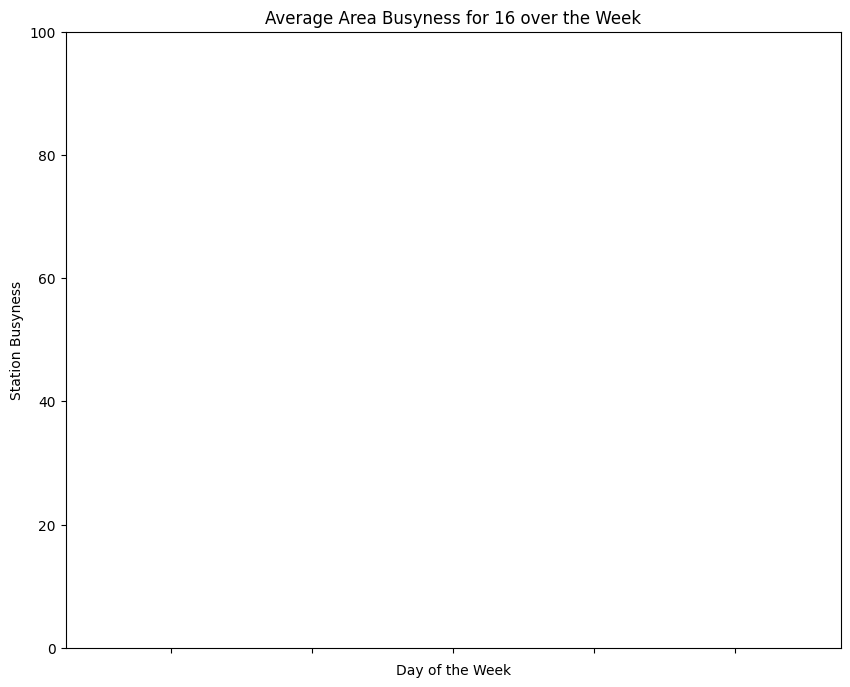

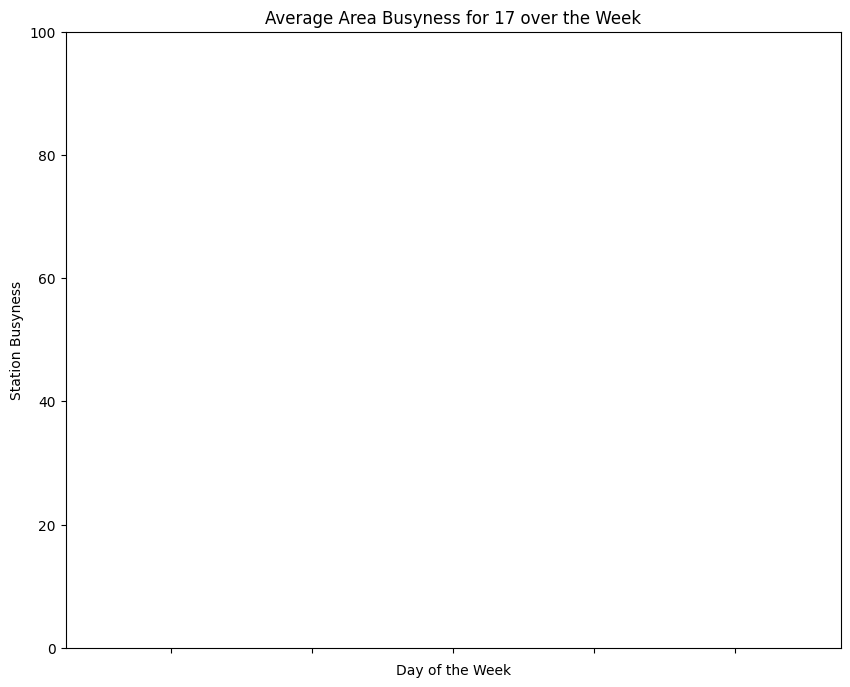

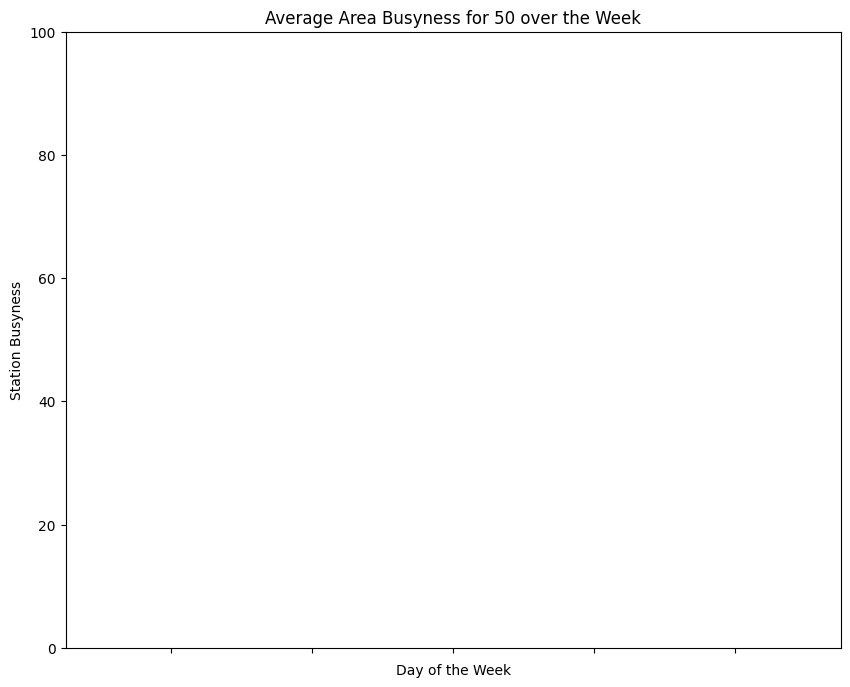

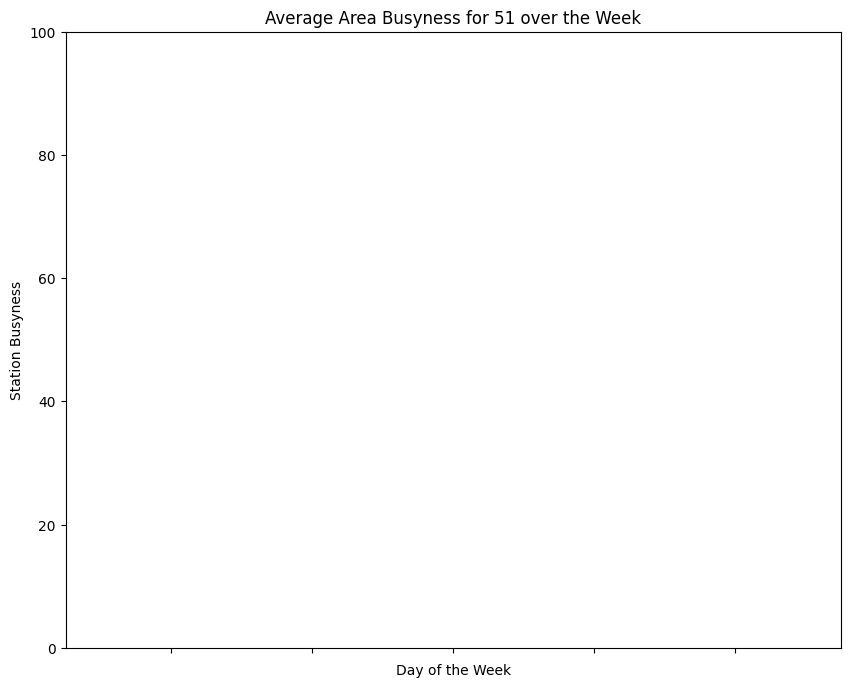

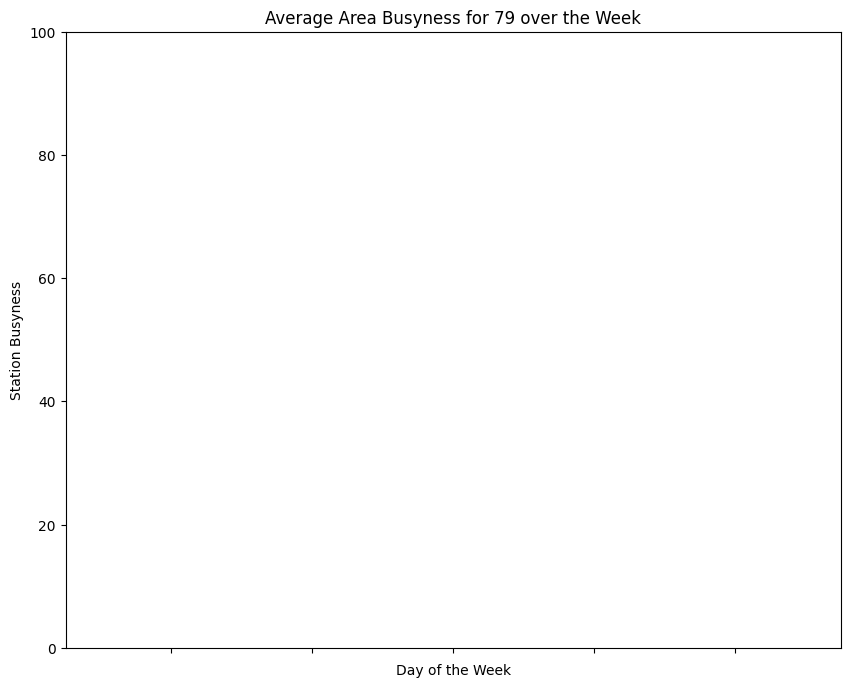

In [33]:
#pick some stations to plot
length = len(df_static['remote_unit_id'])
for i in range(0, 5):
    numb=df_static['remote_unit_id'][i]
    average_area_busyness(numb)